<a href="https://colab.research.google.com/github/Patrick5455/Zimnat-Insurance-Challenge/blob/master/modelling_notebook_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date,  datetime
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, GridSearchCV

In [10]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

In [11]:
!pip install catboost

     |████████████████████████████████| 66.1MB 49kB/s 


In [12]:
!pip install lightgbm

In [13]:
import xgboost as xgb
import catboost as cat
import lightgbm as light
from catboost import CatBoostClassifier, Pool, cv, MetricVisualizer
from sklearn.multiclass import OneVsRestClassifier

In [14]:
! pip install scikit-multilearn

     |████████████████████████████████| 92kB 5.3MB/s 


In [15]:
!pip install community

In [16]:
!pip install networkx

In [17]:
# !pip install ipywidgets

In [18]:
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from skmultilearn.cluster.networkx import NetworkXLabelGraphClusterer
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

In [19]:
from sklearn.metrics import log_loss

> import datasets

In [20]:
# test_path = '../datasets/Test.csv'
# train_path = '../datasets/Train.csv'
# sample_submission_path = '../datasets/SampleSubmission.csv'

mount drive

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


dfine data path from google drive

In [22]:
test_path = '/content/drive/My Drive/Zindi-Competionts/zimnat_Challenge_predicting_insurance_purchase/datasets/Test.csv'
train_path = '/content/drive/My Drive/Zindi-Competionts/zimnat_Challenge_predicting_insurance_purchase/datasets/Train.csv'
sample_submission_path = '/content/drive/My Drive/Zindi-Competionts/zimnat_Challenge_predicting_insurance_purchase/datasets/SampleSubmission.csv'

> define utitlity functions

load data

In [23]:
def load_data(path=""):
    data = pd.read_csv(path)
    return data

move columns

In [4]:
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    
    cols = df.columns.tolist()    
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    
    return(df[seg1 + seg2 + seg3])

transform dates

In [5]:
def transform_dates(df, col_name='', calc_age=False, 
                    birth_year_col_name = '', drop_date=True):
    df[col_name] = pd.to_datetime(df[col_name])
    #fill empty date columns
    if df[col_name].isna().any() == True:
        fill_date = df[col_name].mode()[0]
        df[col_name] =  df[col_name].fillna(fill_date)
    
    #create new datelike features
    todays_date = date.today()
    todays_date = pd.to_datetime(todays_date)
    
    df['duration_till_date'] = (todays_date - df[col_name]).astype('str').apply(lambda x: x.split(' d'
                                                                             )[0].strip()).astype('int64')
    
    df['year'] = df[col_name].apply(lambda x: x.year)
    df['month'] = df[col_name].apply(lambda x: x.year)
    df['week_of_year'] = df[col_name].apply(lambda x: x.weekofyear)
    df['day_of_week'] = df[col_name].apply(lambda x: x.dayofweek)
    
    if calc_age:
        
        df['age'] = df['year'] - df[birth_year_col_name]
        
    
    if drop_date:
        df.drop(columns=[col_name], inplace=True)
        
    
    return df

In [6]:
def val_counts(df, columns=[]):
    for col in columns:
        print("**"*8)
        print(col)
        print("**"*8) 
        print(df[col].value_counts()) 

In [24]:
test_set = load_data(test_path)
train_set = load_data(train_path)
sample_submission = load_data(sample_submission_path)

In [25]:
train_set

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,CP5S02H,1/6/2019,F,M,1981,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2YKDILJ,1/6/2013,M,U,1991,748L,QZYX,90QI,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2S9E81J,1/8/2019,M,M,1990,1X1H,BP09,56SI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,BHDYVFT,1/8/2019,M,M,1990,748L,NO3L,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29127,8SBA93U,1/9/2019,F,M,1974,748L,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
29128,Y73ETTO,1/11/2018,M,M,1987,XX25,Q6J6,90QI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
29129,MVXG2LC,1/2/2019,M,M,1985,BOAS,6PE7,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
29130,BUQ8DQN,1/7/2019,M,M,1989,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [26]:
test_set

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,F86J5PC,1/12/2018,M,M,1984,94KC,DZRV,90QI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,H6141K3,1/10/2019,M,M,1996,1X1H,J9SY,90QI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,RBAYUXZ,1/1/2020,F,W,1968,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,KCBILBQ,1/2/2019,M,M,1989,94KC,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,LSEC1ZJ,1/2/2020,F,M,1982,UAOD,0KID,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0GMU5UH,1/4/2019,F,M,1986,748L,2A7I,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
9996,I9W11CD,1/8/2019,M,M,1980,UAOD,0KID,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
9997,42WTEGT,1/4/2018,M,M,1993,748L,SST3,56SI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9998,8EKC4O9,1/5/2015,F,U,1981,49BM,2A7I,T4MS,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [27]:
sample_submission

,ID X PCODE,Label
0,F86J5PC X P5DA,0
1,F86J5PC X RIBP,0
2,F86J5PC X 8NN1,0
3,F86J5PC X 7POT,0
4,F86J5PC X 66FJ,0
...,...,...
209995,WHII93K X JWFN,0
209996,WHII93K X JZ9D,0
209997,WHII93K X J9JW,0
209998,WHII93K X GHYX,0


### Data Cleaning

In [28]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29132 entries, 0 to 29131
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        29132 non-null  object
 1   join_date                 29130 non-null  object
 2   sex                       29132 non-null  object
 3   marital_status            29132 non-null  object
 4   birth_year                29132 non-null  int64 
 5   branch_code               29132 non-null  object
 6   occupation_code           29132 non-null  object
 7   occupation_category_code  29132 non-null  object
 8   P5DA                      29132 non-null  int64 
 9   RIBP                      29132 non-null  int64 
 10  8NN1                      29132 non-null  int64 
 11  7POT                      29132 non-null  int64 
 12  66FJ                      29132 non-null  int64 
 13  GYSR                      29132 non-null  int64 
 14  SOP4                  

In [29]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        10000 non-null  object
 1   join_date                 9999 non-null   object
 2   sex                       10000 non-null  object
 3   marital_status            10000 non-null  object
 4   birth_year                10000 non-null  int64 
 5   branch_code               10000 non-null  object
 6   occupation_code           10000 non-null  object
 7   occupation_category_code  10000 non-null  object
 8   P5DA                      10000 non-null  int64 
 9   RIBP                      10000 non-null  int64 
 10  8NN1                      10000 non-null  int64 
 11  7POT                      10000 non-null  int64 
 12  66FJ                      10000 non-null  int64 
 13  GYSR                      10000 non-null  int64 
 14  SOP4                   

> Check values in train columns

In [30]:
val_counts(train_set, columns=train_set.columns.to_list())

****************
ID
****************
I4357OD    1
KHDEOIZ    1
HA62IRS    1
F05IQB3    1
CH8C0LI    1
          ..
56RZGNA    1
WQ8WAYU    1
Z8YKOOQ    1
HWB2JRY    1
W4CHXAT    1
Name: ID, Length: 29132, dtype: int64
****************
join_date
****************
1/5/2018      1319
1/5/2019      1199
1/4/2018      1123
1/4/2019      1043
1/1/2019       754
              ... 
7/9/2012         1
23/5/2013        1
22/10/2012       1
8/9/2012         1
11/1/2013        1
Name: join_date, Length: 132, dtype: int64
****************
sex
****************
M    20329
F     8803
Name: sex, dtype: int64
****************
marital_status
****************
M    22913
S     3267
U     2474
W      301
D      135
R       34
P        7
f        1
Name: marital_status, dtype: int64
****************
birth_year
****************
1983    1263
1984    1241
1982    1222
1980    1143
1986    1097
        ... 
1932       1
2011       1
1946       1
2005       1
1936       1
Name: birth_year, Length: 61, dtype: int64

> Check values in test columns

In [31]:
val_counts(test_set, columns=test_set.columns.to_list())

****************
ID
****************
XGNOVG2    1
0EDTY85    1
BBGTOZ4    1
33RKX1L    1
FVSVLM8    1
          ..
XG80SZH    1
Z263ZNU    1
RZO4BL2    1
QZU9EX3    1
OGW95KN    1
Name: ID, Length: 10000, dtype: int64
****************
join_date
****************
1/5/2018      513
1/5/2019      395
1/4/2018      369
1/4/2019      336
1/6/2019      289
             ... 
1/6/2010        2
2/9/2012        1
24/10/2012      1
1/8/2010        1
7/9/2012        1
Name: join_date, Length: 126, dtype: int64
****************
sex
****************
M    6845
F    3155
Name: sex, dtype: int64
****************
marital_status
****************
M    7878
S    1116
U     843
W     105
D      51
R       5
F       1
P       1
Name: marital_status, dtype: int64
****************
birth_year
****************
1984    452
1982    439
1983    433
1985    391
1986    365
1980    363
1988    354
1976    353
1979    345
1989    344
1987    336
1981    336
1975    330
1977    324
1978    318
1973    317
1990    301
19

> For every product codes, there is an `imbalance in the class`. lesser product patronage among the class

In [32]:
train_set.isna().any()

ID                          False
join_date                    True
sex                         False
marital_status              False
birth_year                  False
branch_code                 False
occupation_code             False
occupation_category_code    False
P5DA                        False
RIBP                        False
8NN1                        False
7POT                        False
66FJ                        False
GYSR                        False
SOP4                        False
RVSZ                        False
PYUQ                        False
LJR9                        False
N2MW                        False
AHXO                        False
BSTQ                        False
FM3X                        False
K6QO                        False
QBOL                        False
JWFN                        False
JZ9D                        False
J9JW                        False
GHYX                        False
ECY3                        False
dtype: bool

date as empty rows

In [33]:
test_set.isna().any()

ID                          False
join_date                    True
sex                         False
marital_status              False
birth_year                  False
branch_code                 False
occupation_code             False
occupation_category_code    False
P5DA                        False
RIBP                        False
8NN1                        False
7POT                        False
66FJ                        False
GYSR                        False
SOP4                        False
RVSZ                        False
PYUQ                        False
LJR9                        False
N2MW                        False
AHXO                        False
BSTQ                        False
FM3X                        False
K6QO                        False
QBOL                        False
JWFN                        False
JZ9D                        False
J9JW                        False
GHYX                        False
ECY3                        False
dtype: bool

no more null values in date

### Feature Enngineering

> feature engineer dates and time

In [34]:
train_set = transform_dates(train_set, col_name='join_date', calc_age=True, 
                            birth_year_col_name='birth_year') #drop_date=True) 

In [35]:
test_set = transform_dates(test_set, col_name='join_date', calc_age=True, 
                            birth_year_col_name='birth_year') #drop_date=True) 

In [36]:

train_set.head()

,ID,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3,duration_till_date,year,month,week_of_year,day_of_week,age
0,4WKQSBB,F,M,1987,1X1H,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,613,2019,2019,1,2,32
1,CP5S02H,F,M,1981,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,609,2019,2019,1,6,38
2,2YKDILJ,M,U,1991,748L,QZYX,90QI,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2800,2013,2013,1,6,22
3,2S9E81J,M,M,1990,1X1H,BP09,56SI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,607,2019,2019,2,1,29
4,BHDYVFT,M,M,1990,748L,NO3L,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,607,2019,2019,2,1,29


In [ ]:
test_set.head()

,ID,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,...,JZ9D,J9JW,GHYX,ECY3,duration_till_date,year,month,week_of_year,day_of_week,age
0,F86J5PC,M,M,1984,94KC,DZRV,90QI,0,0,0,...,0,0,0,0,967,2018,2018,2,4,34
1,H6141K3,M,M,1996,1X1H,J9SY,90QI,0,0,0,...,0,0,0,0,604,2019,2019,2,3,23
2,RBAYUXZ,F,W,1968,UAOD,2A7I,T4MS,0,0,0,...,0,0,0,0,248,2020,2020,1,2,52
3,KCBILBQ,M,M,1989,94KC,2A7I,T4MS,0,0,0,...,0,0,0,0,612,2019,2019,1,2,30
4,LSEC1ZJ,F,M,1982,UAOD,0KID,T4MS,0,0,0,...,1,0,0,0,247,2020,2020,1,3,38


In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29132 entries, 0 to 29131
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        29132 non-null  object
 1   sex                       29132 non-null  object
 2   marital_status            29132 non-null  object
 3   birth_year                29132 non-null  int64 
 4   branch_code               29132 non-null  object
 5   occupation_code           29132 non-null  object
 6   occupation_category_code  29132 non-null  object
 7   P5DA                      29132 non-null  int64 
 8   RIBP                      29132 non-null  int64 
 9   8NN1                      29132 non-null  int64 
 10  7POT                      29132 non-null  int64 
 11  66FJ                      29132 non-null  int64 
 12  GYSR                      29132 non-null  int64 
 13  SOP4                      29132 non-null  int64 
 14  RVSZ                  

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29132 entries, 0 to 29131
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        29132 non-null  object
 1   sex                       29132 non-null  object
 2   marital_status            29132 non-null  object
 3   birth_year                29132 non-null  int64 
 4   branch_code               29132 non-null  object
 5   occupation_code           29132 non-null  object
 6   occupation_category_code  29132 non-null  object
 7   P5DA                      29132 non-null  int64 
 8   RIBP                      29132 non-null  int64 
 9   8NN1                      29132 non-null  int64 
 10  7POT                      29132 non-null  int64 
 11  66FJ                      29132 non-null  int64 
 12  GYSR                      29132 non-null  int64 
 13  SOP4                      29132 non-null  int64 
 14  RVSZ                  

> reorder columns

In [ ]:
train_set = movecol(train_set, ['age','duration_till_date', 'year', 'month', 
                                'week_of_year', 'day_of_week'], ref_col='ID')

In [ ]:
test_set = movecol(test_set, ['age','duration_till_date', 'year', 'month', 
                                'week_of_year', 'day_of_week'], ref_col='ID')

In [ ]:
train_set.head()

,ID,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,...,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,32,612,2019,2019,1,2,F,M,1987,...,0,0,0,1,0,0,0,0,0,0
1,CP5S02H,38,608,2019,2019,1,6,F,M,1981,...,0,0,0,1,0,0,0,0,0,0
2,2YKDILJ,22,2799,2013,2013,1,6,M,U,1991,...,0,0,0,0,0,0,0,0,0,1
3,2S9E81J,29,606,2019,2019,2,1,M,M,1990,...,0,0,0,1,0,0,0,0,0,0
4,BHDYVFT,29,606,2019,2019,2,1,M,M,1990,...,0,0,0,0,0,0,1,1,0,0


In [ ]:
test_set.head()

,ID,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,...,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,F86J5PC,34,967,2018,2018,2,4,M,M,1984,...,0,0,0,0,0,0,0,0,0,0
1,H6141K3,23,604,2019,2019,2,3,M,M,1996,...,0,0,0,1,0,0,0,0,0,0
2,RBAYUXZ,52,248,2020,2020,1,2,F,W,1968,...,0,0,0,1,0,0,0,0,0,0
3,KCBILBQ,30,612,2019,2019,1,2,M,M,1989,...,0,0,0,0,0,0,0,0,0,0
4,LSEC1ZJ,38,247,2020,2020,1,3,F,M,1982,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
train_set.columns

Index(['ID', 'age', 'duration_till_date', 'year', 'month', 'week_of_year',
       'day_of_week', 'sex', 'marital_status', 'birth_year', 'branch_code',
       'occupation_code', 'occupation_category_code', 'P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3'],
      dtype='object')

#### Further Feature Engineering

-  get product use frequency per user

In [ ]:
train_product_ids  = train_set.columns.to_list()[13:]
train_product_ids

['P5DA',
 'RIBP',
 '8NN1',
 '7POT',
 '66FJ',
 'GYSR',
 'SOP4',
 'RVSZ',
 'PYUQ',
 'LJR9',
 'N2MW',
 'AHXO',
 'BSTQ',
 'FM3X',
 'K6QO',
 'QBOL',
 'JWFN',
 'JZ9D',
 'J9JW',
 'GHYX',
 'ECY3']

In [ ]:
test_product_ids  = test_set.columns.to_list()[13:]
test_product_ids

['P5DA',
 'RIBP',
 '8NN1',
 '7POT',
 '66FJ',
 'GYSR',
 'SOP4',
 'RVSZ',
 'PYUQ',
 'LJR9',
 'N2MW',
 'AHXO',
 'BSTQ',
 'FM3X',
 'K6QO',
 'QBOL',
 'JWFN',
 'JZ9D',
 'J9JW',
 'GHYX',
 'ECY3']

In [ ]:
f'lenght of insurance products {len(train_product_ids)}'

'lenght of insurance products 21'

In [ ]:
non_product_cols = train_set.iloc[:, :12].columns.tolist()

In [ ]:
non_product_cols

['ID',
 'age',
 'duration_till_date',
 'year',
 'month',
 'week_of_year',
 'day_of_week',
 'sex',
 'marital_status',
 'birth_year',
 'branch_code',
 'occupation_code']

In [ ]:
train_set=train_set.melt(id_vars=non_product_cols, value_vars=train_product_ids, var_name='product_ids', value_name='labels')

In [ ]:
test_set=test_set.melt(id_vars=non_product_cols, value_vars=test_product_ids, var_name='product_ids', value_name='labels')

In [ ]:
train_set.head()

,ID,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels
0,4WKQSBB,32,612,2019,2019,1,2,F,M,1987,1X1H,2A7I,P5DA,0
1,CP5S02H,38,608,2019,2019,1,6,F,M,1981,UAOD,2A7I,P5DA,0
2,2YKDILJ,22,2799,2013,2013,1,6,M,U,1991,748L,QZYX,P5DA,0
3,2S9E81J,29,606,2019,2019,2,1,M,M,1990,1X1H,BP09,P5DA,0
4,BHDYVFT,29,606,2019,2019,2,1,M,M,1990,748L,NO3L,P5DA,0


In [ ]:
test_set.head()

,ID,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels
0,F86J5PC,34,967,2018,2018,2,4,M,M,1984,94KC,DZRV,P5DA,0
1,H6141K3,23,604,2019,2019,2,3,M,M,1996,1X1H,J9SY,P5DA,0
2,RBAYUXZ,52,248,2020,2020,1,2,F,W,1968,UAOD,2A7I,P5DA,0
3,KCBILBQ,30,612,2019,2019,1,2,M,M,1989,94KC,2A7I,P5DA,0
4,LSEC1ZJ,38,247,2020,2020,1,3,F,M,1982,UAOD,0KID,P5DA,0


> sort dataset by customer ID and product id

In [ ]:
train_set.sort_values(by=['ID','product_ids' ], inplace=True)

In [ ]:
test_set.sort_values(by=['ID','product_ids' ], inplace=True)

> concatenate user ID and producct id

In [ ]:
train_set['ID X PCODE'] = train_set.ID+' X '+train_set.product_ids

In [ ]:
train_set['ID X PCODE']

135107    001IIBS X 66FJ
105975    001IIBS X 7POT
76843     001IIBS X 8NN1
339031    001IIBS X AHXO
368163    001IIBS X BSTQ
               ...      
260571    ZZZU5BE X PYUQ
464495    ZZZU5BE X QBOL
56647     ZZZU5BE X RIBP
231439    ZZZU5BE X RVSZ
202307    ZZZU5BE X SOP4
Name: ID X PCODE, Length: 611772, dtype: object

In [ ]:
test_set['ID X PCODE'] = test_set.ID+' X '+test_set.product_ids
test_set['ID X PCODE']

49842     0021EE1 X 66FJ
39842     0021EE1 X 7POT
29842     0021EE1 X 8NN1
119842    0021EE1 X AHXO
129842    0021EE1 X BSTQ
               ...      
86019     ZZYM5CT X PYUQ
156019    ZZYM5CT X QBOL
16019     ZZYM5CT X RIBP
76019     ZZYM5CT X RVSZ
66019     ZZYM5CT X SOP4
Name: ID X PCODE, Length: 210000, dtype: object

In [ ]:
train_set = movecol(train_set, cols_to_move=['ID X PCODE'], ref_col='ID')

In [ ]:
test_set = movecol(test_set, cols_to_move=['ID X PCODE'], ref_col='ID')

<!-- > concatenate product ID and customer ID -->

In [ ]:
train_set.head(2)

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels
135107,001IIBS,001IIBS X 66FJ,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,66FJ,0
105975,001IIBS,001IIBS X 7POT,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,7POT,0


In [ ]:
test_ = train_set.copy()

In [ ]:
test_

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels
135107,001IIBS,001IIBS X 66FJ,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,66FJ,0
105975,001IIBS,001IIBS X 7POT,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,7POT,0
76843,001IIBS,001IIBS X 8NN1,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,8NN1,0
339031,001IIBS,001IIBS X AHXO,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,AHXO,0
368163,001IIBS,001IIBS X BSTQ,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,BSTQ,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260571,ZZZU5BE,ZZZU5BE X PYUQ,25,609,2019,2019,1,5,M,M,1994,94KC,2A7I,PYUQ,0
464495,ZZZU5BE,ZZZU5BE X QBOL,25,609,2019,2019,1,5,M,M,1994,94KC,2A7I,QBOL,0
56647,ZZZU5BE,ZZZU5BE X RIBP,25,609,2019,2019,1,5,M,M,1994,94KC,2A7I,RIBP,0
231439,ZZZU5BE,ZZZU5BE X RVSZ,25,609,2019,2019,1,5,M,M,1994,94KC,2A7I,RVSZ,1


> I would like to score each product based on number of purchases

In [ ]:
class_counts_per_products = pd.DataFrame(test_.groupby(['product_ids', 'labels'])['labels'].count()
            ).rename(columns={'labels':'vals'})

In [ ]:
class_counts_per_products.head()

vals
product_ids labels       
66FJ        0       28793
            1         339
7POT        0       28816
            1         316
8NN1        0       28975

In [ ]:
class_counts_per_products = class_counts_per_products.reset_index().pivot(
    index='product_ids', columns='labels')

In [ ]:
class_counts_per_products

vals       
labels           0      1
product_ids              
66FJ         28793    339
7POT         28816    316
8NN1         28975    157
AHXO         28593    539
BSTQ         28808    324
ECY3         28030   1102
FM3X         29022    110
GHYX         28230    902
GYSR         29128      4
J9JW         27714   1418
JWFN         28821    311
JZ9D         27707   1425
K6QO          7503  21629
LJR9         28778    354
N2MW         28294    838
P5DA         29092     40
PYUQ         26959   2173
QBOL         22299   6833
RIBP         27352   1780
RVSZ          3804  25328
SOP4         28701    431

In [ ]:
class_counts_per_products = class_counts_per_products['vals']

In [ ]:
class_counts_per_products

labels,0,1
product_ids,,
66FJ,28793,339
7POT,28816,316
8NN1,28975,157
AHXO,28593,539
BSTQ,28808,324
ECY3,28030,1102
FM3X,29022,110
GHYX,28230,902
GYSR,29128,4


In [ ]:
class_counts_per_products = class_counts_per_products.reset_index().rename(columns={0:'no_purchase', 1:'purchase'})

In [ ]:
class_counts_per_products

labels,product_ids,no_purchase,purchase
0,66FJ,28793,339
1,7POT,28816,316
2,8NN1,28975,157
3,AHXO,28593,539
4,BSTQ,28808,324
5,ECY3,28030,1102
6,FM3X,29022,110
7,GHYX,28230,902
8,GYSR,29128,4
9,J9JW,27714,1418


In [ ]:
class_counts_per_products.sort_values(by='purchase', ascending=False, inplace=True)

In [ ]:
class_counts_per_products

labels,product_ids,no_purchase,purchase
19,RVSZ,3804,25328
12,K6QO,7503,21629
17,QBOL,22299,6833
16,PYUQ,26959,2173
18,RIBP,27352,1780
11,JZ9D,27707,1425
9,J9JW,27714,1418
5,ECY3,28030,1102
7,GHYX,28230,902
14,N2MW,28294,838


In [ ]:
class_counts_per_products.columns.name = None

In [ ]:
class_counts_per_products

,product_ids,no_purchase,purchase
19,RVSZ,3804,25328
12,K6QO,7503,21629
17,QBOL,22299,6833
16,PYUQ,26959,2173
18,RIBP,27352,1780
11,JZ9D,27707,1425
9,J9JW,27714,1418
5,ECY3,28030,1102
7,GHYX,28230,902
14,N2MW,28294,838


In [ ]:
patronage_label = pd.DataFrame(class_counts_per_products.purchase.describe(percentiles=[
    .1,.25, .50, .75, 1])[['10%','25%','50%', '75%', '100%']]).reset_index().rename(columns={
    'index':'patronage', 'purchase':'value'})

In [ ]:
patronage_label

,patronage,value
0,10%,110.0
1,25%,316.0
2,50%,539.0
3,75%,1425.0
4,100%,25328.0


In [ ]:
patronage_label.rename(index={0:'very_poor', 1:'poor', 2:'avg', 3:'good', 4:'excellent'}, inplace=True)

In [ ]:
patronage_label

,patronage,value
very_poor,10%,110.0
poor,25%,316.0
avg,50%,539.0
good,75%,1425.0
excellent,100%,25328.0


In [ ]:
patronage_label.value = patronage_label.value.astype('int64')

In [ ]:
patronage_label

,patronage,value
very_poor,10%,110
poor,25%,316
avg,50%,539
good,75%,1425
excellent,100%,25328


In [ ]:
patronage_label

,patronage,value
very_poor,10%,110
poor,25%,316
avg,50%,539
good,75%,1425
excellent,100%,25328


In [ ]:
pat_dic = patronage_label.value.to_dict()
pat_dic 

{'very_poor': 110, 'poor': 316, 'avg': 539, 'good': 1425, 'excellent': 25328}

In [ ]:
pat_dic2 = {}
for k, v in pat_dic.items():
    pat_dic2[v] = k

In [ ]:
pat_dic2

{110: 'very_poor', 316: 'poor', 539: 'avg', 1425: 'good', 25328: 'excellent'}

> Define function to label a product in relation to percentile

- 10% very poor

- 25% poor

- 50% average

- 75% good

- 100% excellent

In [ ]:
def label_patronage(df, col_name=''):
    
    ratings = pd.DataFrame(df[col_name].describe(percentiles=[
    .1,.25, .50, .75, 1])[['10%','25%','50%', '75%', '100%']]).reset_index().rename(columns={
    'index':'patronage', 'purchase':'value'})
    
    
    

In [ ]:
labels = []
for i in class_counts_per_products.purchase:
    if i in range(0, pat_dic['very_poor']+1):
        labels.append('very_poor')
    elif i in range(pat_dic['very_poor']+1, pat_dic['poor']+1):
        labels.append('poor')
    elif i in range(pat_dic['poor']+1, pat_dic['avg']+1):
        labels.append('avg')
    elif i in range(pat_dic['avg']+1, pat_dic['good']+1):
        labels.append('good')
    elif i in range(pat_dic['good']+1, pat_dic['excellent']+1):
        labels.append('excellent')

In [ ]:
class_counts_per_products['ranks'] = labels

In [ ]:
class_counts_per_products

,product_ids,no_purchase,purchase,ranks
19,RVSZ,3804,25328,excellent
12,K6QO,7503,21629,excellent
17,QBOL,22299,6833,excellent
16,PYUQ,26959,2173,excellent
18,RIBP,27352,1780,excellent
11,JZ9D,27707,1425,good
9,J9JW,27714,1418,good
5,ECY3,28030,1102,good
7,GHYX,28230,902,good
14,N2MW,28294,838,good


In [ ]:
rank_dic = dict(zip(class_counts_per_products.product_ids.to_list(), class_counts_per_products.ranks.to_list())) 

In [ ]:
rank_dic

{'RVSZ': 'excellent',
 'K6QO': 'excellent',
 'QBOL': 'excellent',
 'PYUQ': 'excellent',
 'RIBP': 'excellent',
 'JZ9D': 'good',
 'J9JW': 'good',
 'ECY3': 'good',
 'GHYX': 'good',
 'N2MW': 'good',
 'AHXO': 'avg',
 'SOP4': 'avg',
 'LJR9': 'avg',
 '66FJ': 'avg',
 'BSTQ': 'avg',
 '7POT': 'poor',
 'JWFN': 'poor',
 '8NN1': 'poor',
 'FM3X': 'very_poor',
 'P5DA': 'very_poor',
 'GYSR': 'very_poor'}

> Assign rank to train set

In [ ]:
train_set

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels
135107,001IIBS,001IIBS X 66FJ,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,66FJ,0
105975,001IIBS,001IIBS X 7POT,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,7POT,0
76843,001IIBS,001IIBS X 8NN1,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,8NN1,0
339031,001IIBS,001IIBS X AHXO,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,AHXO,0
368163,001IIBS,001IIBS X BSTQ,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,BSTQ,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260571,ZZZU5BE,ZZZU5BE X PYUQ,25,609,2019,2019,1,5,M,M,1994,94KC,2A7I,PYUQ,0
464495,ZZZU5BE,ZZZU5BE X QBOL,25,609,2019,2019,1,5,M,M,1994,94KC,2A7I,QBOL,0
56647,ZZZU5BE,ZZZU5BE X RIBP,25,609,2019,2019,1,5,M,M,1994,94KC,2A7I,RIBP,0
231439,ZZZU5BE,ZZZU5BE X RVSZ,25,609,2019,2019,1,5,M,M,1994,94KC,2A7I,RVSZ,1


In [ ]:
train_ranks =[]
for i in train_set.product_ids:
    for k,v in rank_dic.items():
        if i.strip() == k.strip():
            train_ranks.append(v)

In [ ]:
train_ranks[0:5]

['avg', 'poor', 'poor', 'avg', 'avg']

In [ ]:
train_set['product_ranks'] = train_ranks

In [ ]:
train_set.head(5)

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels,product_ranks
135107,001IIBS,001IIBS X 66FJ,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,66FJ,0,avg
105975,001IIBS,001IIBS X 7POT,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,7POT,0,poor
76843,001IIBS,001IIBS X 8NN1,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,8NN1,0,poor
339031,001IIBS,001IIBS X AHXO,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,AHXO,0,avg
368163,001IIBS,001IIBS X BSTQ,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,BSTQ,0,avg


> Assign rank to test set

In [ ]:
test_set

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels
49842,0021EE1,0021EE1 X 66FJ,55,609,2019,2019,1,5,F,W,1964,748L,0KID,66FJ,0
39842,0021EE1,0021EE1 X 7POT,55,609,2019,2019,1,5,F,W,1964,748L,0KID,7POT,0
29842,0021EE1,0021EE1 X 8NN1,55,609,2019,2019,1,5,F,W,1964,748L,0KID,8NN1,0
119842,0021EE1,0021EE1 X AHXO,55,609,2019,2019,1,5,F,W,1964,748L,0KID,AHXO,0
129842,0021EE1,0021EE1 X BSTQ,55,609,2019,2019,1,5,F,W,1964,748L,0KID,BSTQ,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86019,ZZYM5CT,ZZYM5CT X PYUQ,38,975,2018,2018,1,3,M,M,1980,UAOD,SST3,PYUQ,0
156019,ZZYM5CT,ZZYM5CT X QBOL,38,975,2018,2018,1,3,M,M,1980,UAOD,SST3,QBOL,0
16019,ZZYM5CT,ZZYM5CT X RIBP,38,975,2018,2018,1,3,M,M,1980,UAOD,SST3,RIBP,0
76019,ZZYM5CT,ZZYM5CT X RVSZ,38,975,2018,2018,1,3,M,M,1980,UAOD,SST3,RVSZ,0


In [ ]:
test_ranks =[]
for i in test_set.product_ids:
    for k,v in rank_dic.items():
        if i.strip() == k.strip():
            test_ranks.append(v)

In [ ]:
test_ranks[0:5]

['avg', 'poor', 'poor', 'avg', 'avg']

In [ ]:
test_set['product_ranks'] = test_ranks

In [ ]:
test_set.head(5)

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels,product_ranks
49842,0021EE1,0021EE1 X 66FJ,55,609,2019,2019,1,5,F,W,1964,748L,0KID,66FJ,0,avg
39842,0021EE1,0021EE1 X 7POT,55,609,2019,2019,1,5,F,W,1964,748L,0KID,7POT,0,poor
29842,0021EE1,0021EE1 X 8NN1,55,609,2019,2019,1,5,F,W,1964,748L,0KID,8NN1,0,poor
119842,0021EE1,0021EE1 X AHXO,55,609,2019,2019,1,5,F,W,1964,748L,0KID,AHXO,0,avg
129842,0021EE1,0021EE1 X BSTQ,55,609,2019,2019,1,5,F,W,1964,748L,0KID,BSTQ,0,avg


> Ordinally encode Product Ranks

In [ ]:
train_set.product_ranks.value_counts()

excellent    145660
avg          145660
good         145660
poor          87396
very_poor     87396
Name: product_ranks, dtype: int64

In [ ]:
train_set.head(3)

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels,product_ranks
135107,001IIBS,001IIBS X 66FJ,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,66FJ,0,avg
105975,001IIBS,001IIBS X 7POT,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,7POT,0,poor
76843,001IIBS,001IIBS X 8NN1,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,8NN1,0,poor


In [ ]:
train_set.product_ranks = train_set.product_ranks.map({'excellent':5, 'good':4, 'avg':3,
                            'poor':2, 'very_poor':1})

In [ ]:
train_set

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels,product_ranks
135107,001IIBS,001IIBS X 66FJ,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,66FJ,0,3
105975,001IIBS,001IIBS X 7POT,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,7POT,0,2
76843,001IIBS,001IIBS X 8NN1,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,8NN1,0,2
339031,001IIBS,001IIBS X AHXO,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,AHXO,0,3
368163,001IIBS,001IIBS X BSTQ,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,BSTQ,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260571,ZZZU5BE,ZZZU5BE X PYUQ,25,609,2019,2019,1,5,M,M,1994,94KC,2A7I,PYUQ,0,5
464495,ZZZU5BE,ZZZU5BE X QBOL,25,609,2019,2019,1,5,M,M,1994,94KC,2A7I,QBOL,0,5
56647,ZZZU5BE,ZZZU5BE X RIBP,25,609,2019,2019,1,5,M,M,1994,94KC,2A7I,RIBP,0,5
231439,ZZZU5BE,ZZZU5BE X RVSZ,25,609,2019,2019,1,5,M,M,1994,94KC,2A7I,RVSZ,1,5


In [ ]:
test_set.product_ranks.value_counts()

excellent    50000
avg          50000
good         50000
poor         30000
very_poor    30000
Name: product_ranks, dtype: int64

In [ ]:
test_set.head(3)

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels,product_ranks
49842,0021EE1,0021EE1 X 66FJ,55,609,2019,2019,1,5,F,W,1964,748L,0KID,66FJ,0,avg
39842,0021EE1,0021EE1 X 7POT,55,609,2019,2019,1,5,F,W,1964,748L,0KID,7POT,0,poor
29842,0021EE1,0021EE1 X 8NN1,55,609,2019,2019,1,5,F,W,1964,748L,0KID,8NN1,0,poor


In [ ]:
test_set.product_ranks = test_set.product_ranks.map({'excellent':5, 'good':4, 'avg':3,
                            'poor':2, 'very_poor':1})

In [ ]:
test_set

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels,product_ranks
49842,0021EE1,0021EE1 X 66FJ,55,609,2019,2019,1,5,F,W,1964,748L,0KID,66FJ,0,3
39842,0021EE1,0021EE1 X 7POT,55,609,2019,2019,1,5,F,W,1964,748L,0KID,7POT,0,2
29842,0021EE1,0021EE1 X 8NN1,55,609,2019,2019,1,5,F,W,1964,748L,0KID,8NN1,0,2
119842,0021EE1,0021EE1 X AHXO,55,609,2019,2019,1,5,F,W,1964,748L,0KID,AHXO,0,3
129842,0021EE1,0021EE1 X BSTQ,55,609,2019,2019,1,5,F,W,1964,748L,0KID,BSTQ,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86019,ZZYM5CT,ZZYM5CT X PYUQ,38,975,2018,2018,1,3,M,M,1980,UAOD,SST3,PYUQ,0,5
156019,ZZYM5CT,ZZYM5CT X QBOL,38,975,2018,2018,1,3,M,M,1980,UAOD,SST3,QBOL,0,5
16019,ZZYM5CT,ZZYM5CT X RIBP,38,975,2018,2018,1,3,M,M,1980,UAOD,SST3,RIBP,0,5
76019,ZZYM5CT,ZZYM5CT X RVSZ,38,975,2018,2018,1,3,M,M,1980,UAOD,SST3,RVSZ,0,5


> Deduct score where user did not purchase

Train Set

In [ ]:
train_zeroes_index = train_set.query('labels == 0').index

In [ ]:
train_zero_score = [0]*len(train_zeroes_index)

In [ ]:
train_set.loc[train_zeroes_index, 'product_ranks']  = train_zero_score

In [ ]:
train_set

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels,product_ranks
135107,001IIBS,001IIBS X 66FJ,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,66FJ,0,0
105975,001IIBS,001IIBS X 7POT,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,7POT,0,0
76843,001IIBS,001IIBS X 8NN1,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,8NN1,0,0
339031,001IIBS,001IIBS X AHXO,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,AHXO,0,0
368163,001IIBS,001IIBS X BSTQ,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,BSTQ,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260571,ZZZU5BE,ZZZU5BE X PYUQ,25,609,2019,2019,1,5,M,M,1994,94KC,2A7I,PYUQ,0,0
464495,ZZZU5BE,ZZZU5BE X QBOL,25,609,2019,2019,1,5,M,M,1994,94KC,2A7I,QBOL,0,0
56647,ZZZU5BE,ZZZU5BE X RIBP,25,609,2019,2019,1,5,M,M,1994,94KC,2A7I,RIBP,0,0
231439,ZZZU5BE,ZZZU5BE X RVSZ,25,609,2019,2019,1,5,M,M,1994,94KC,2A7I,RVSZ,1,5


Test Set

In [ ]:
test_zeroes_index = test_set.query('labels == 0').index

In [ ]:
len(test_zeroes_index)

197147

In [ ]:
test_zero_scores = [0]*len(test_zeroes_index)

In [ ]:
test_set.loc[test_zeroes_index, 'product_ranks']  = test_zero_scores

In [ ]:
test_set

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,labels,product_ranks
49842,0021EE1,0021EE1 X 66FJ,55,609,2019,2019,1,5,F,W,1964,748L,0KID,66FJ,0,0
39842,0021EE1,0021EE1 X 7POT,55,609,2019,2019,1,5,F,W,1964,748L,0KID,7POT,0,0
29842,0021EE1,0021EE1 X 8NN1,55,609,2019,2019,1,5,F,W,1964,748L,0KID,8NN1,0,0
119842,0021EE1,0021EE1 X AHXO,55,609,2019,2019,1,5,F,W,1964,748L,0KID,AHXO,0,0
129842,0021EE1,0021EE1 X BSTQ,55,609,2019,2019,1,5,F,W,1964,748L,0KID,BSTQ,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86019,ZZYM5CT,ZZYM5CT X PYUQ,38,975,2018,2018,1,3,M,M,1980,UAOD,SST3,PYUQ,0,0
156019,ZZYM5CT,ZZYM5CT X QBOL,38,975,2018,2018,1,3,M,M,1980,UAOD,SST3,QBOL,0,0
16019,ZZYM5CT,ZZYM5CT X RIBP,38,975,2018,2018,1,3,M,M,1980,UAOD,SST3,RIBP,0,0
76019,ZZYM5CT,ZZYM5CT X RVSZ,38,975,2018,2018,1,3,M,M,1980,UAOD,SST3,RVSZ,0,0


#### All done !

In [ ]:
train_set=movecol(train_set, cols_to_move=['product_ranks'], ref_col='product_ids')

In [ ]:
test_set=movecol(test_set, cols_to_move=['product_ranks'], ref_col='product_ids')

In [ ]:
train_set.head()

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,product_ranks,labels
135107,001IIBS,001IIBS X 66FJ,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,66FJ,0,0
105975,001IIBS,001IIBS X 7POT,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,7POT,0,0
76843,001IIBS,001IIBS X 8NN1,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,8NN1,0,0
339031,001IIBS,001IIBS X AHXO,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,AHXO,0,0
368163,001IIBS,001IIBS X BSTQ,36,606,2019,2019,2,1,F,M,1983,9F9T,31JW,BSTQ,0,0


In [ ]:
test_set.head()

,ID,ID X PCODE,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,product_ranks,labels
49842,0021EE1,0021EE1 X 66FJ,55,609,2019,2019,1,5,F,W,1964,748L,0KID,66FJ,0,0
39842,0021EE1,0021EE1 X 7POT,55,609,2019,2019,1,5,F,W,1964,748L,0KID,7POT,0,0
29842,0021EE1,0021EE1 X 8NN1,55,609,2019,2019,1,5,F,W,1964,748L,0KID,8NN1,0,0
119842,0021EE1,0021EE1 X AHXO,55,609,2019,2019,1,5,F,W,1964,748L,0KID,AHXO,0,0
129842,0021EE1,0021EE1 X BSTQ,55,609,2019,2019,1,5,F,W,1964,748L,0KID,BSTQ,0,0


> Check Class Imbalance

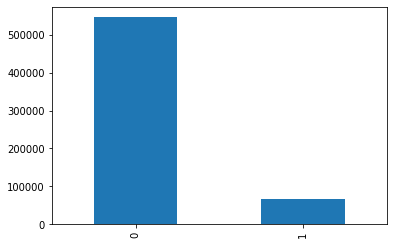

In [ ]:
train_set.labels.value_counts().plot.bar();

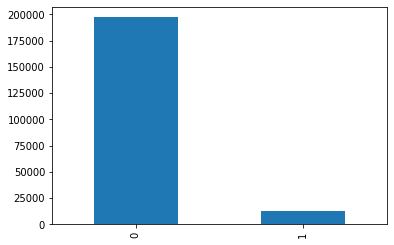

In [ ]:
test_set.labels.value_counts().plot.bar();

> convert all int  type to float type

In [ ]:
train_set.dtypes

ID                    object
ID X PCODE            object
age                    int64
duration_till_date     int64
year                   int64
month                  int64
week_of_year           int64
day_of_week            int64
sex                   object
marital_status        object
birth_year             int64
branch_code           object
occupation_code       object
product_ids           object
product_ranks          int64
labels                 int64
dtype: object

In [ ]:
for i in train_set.select_dtypes('int64').columns.to_list():
    train_set[i] = train_set[i].astype('float')

In [ ]:
train_set.dtypes

ID                     object
ID X PCODE             object
age                   float64
duration_till_date    float64
year                  float64
month                 float64
week_of_year          float64
day_of_week           float64
sex                    object
marital_status         object
birth_year            float64
branch_code            object
occupation_code        object
product_ids            object
product_ranks         float64
labels                float64
dtype: object

In [ ]:
test_set.dtypes#('int64').astype('float')

ID                    object
ID X PCODE            object
age                    int64
duration_till_date     int64
year                   int64
month                  int64
week_of_year           int64
day_of_week            int64
sex                   object
marital_status        object
birth_year             int64
branch_code           object
occupation_code       object
product_ids           object
product_ranks          int64
labels                 int64
dtype: object

In [ ]:
for i in test_set.select_dtypes('int64').columns.to_list():
    test_set[i] = test_set[i].astype('float')

In [ ]:
test_set.dtypes

ID                     object
ID X PCODE             object
age                   float64
duration_till_date    float64
year                  float64
month                 float64
week_of_year          float64
day_of_week           float64
sex                    object
marital_status         object
birth_year            float64
branch_code            object
occupation_code        object
product_ids            object
product_ranks         float64
labels                float64
dtype: object

### Modelling

Algorithms:

- Catboost

- XGboost

- LGBM

Techniques

- cross validation

- hp-tuning

- over-sampling imbalance

#### Test Catboost Using Cross Validation

In [ ]:
X_cat_train, y_cat_train = train_set.drop(columns=['labels', 'ID', 'ID X PCODE'
                                                  ],axis=1), train_set.labels 

In [ ]:
X_cat_train

,age,duration_till_date,year,month,week_of_year,day_of_week,sex,marital_status,birth_year,branch_code,occupation_code,product_ids,product_ranks
135107,36.0,606.0,2019.0,2019.0,2.0,1.0,F,M,1983.0,9F9T,31JW,66FJ,0.0
105975,36.0,606.0,2019.0,2019.0,2.0,1.0,F,M,1983.0,9F9T,31JW,7POT,0.0
76843,36.0,606.0,2019.0,2019.0,2.0,1.0,F,M,1983.0,9F9T,31JW,8NN1,0.0
339031,36.0,606.0,2019.0,2019.0,2.0,1.0,F,M,1983.0,9F9T,31JW,AHXO,0.0
368163,36.0,606.0,2019.0,2019.0,2.0,1.0,F,M,1983.0,9F9T,31JW,BSTQ,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260571,25.0,609.0,2019.0,2019.0,1.0,5.0,M,M,1994.0,94KC,2A7I,PYUQ,0.0
464495,25.0,609.0,2019.0,2019.0,1.0,5.0,M,M,1994.0,94KC,2A7I,QBOL,0.0
56647,25.0,609.0,2019.0,2019.0,1.0,5.0,M,M,1994.0,94KC,2A7I,RIBP,0.0
231439,25.0,609.0,2019.0,2019.0,1.0,5.0,M,M,1994.0,94KC,2A7I,RVSZ,5.0


In [ ]:
y_cat_train

135107    0.0
105975    0.0
76843     0.0
339031    0.0
368163    0.0
         ... 
260571    0.0
464495    0.0
56647     0.0
231439    1.0
202307    0.0
Name: labels, Length: 611772, dtype: float64

> Deal with Imbalances

In [ ]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=2)
# X_cat_train, y_cat_train = sm.fit_sample(X_cat_train, y_cat_train.ravel())

> get column indices of categorical variables

In [ ]:
cat_features = np.where((X_cat_train.dtypes != np.float))[0]
cat_features

array([ 6,  7,  9, 10, 11])

In [ ]:
feature_names = X_cat_train.columns.tolist()
feature_names

['age',
 'duration_till_date',
 'year',
 'month',
 'week_of_year',
 'day_of_week',
 'sex',
 'marital_status',
 'birth_year',
 'branch_code',
 'occupation_code',
 'product_ids',
 'product_ranks']

In [ ]:
X_cat_train_array = X_cat_train.values

In [ ]:
X_cat_train_array

array([[36.0, 606.0, 2019.0, ..., '31JW', '66FJ', 0.0],
       [36.0, 606.0, 2019.0, ..., '31JW', '7POT', 0.0],
       [36.0, 606.0, 2019.0, ..., '31JW', '8NN1', 0.0],
       ...,
       [25.0, 609.0, 2019.0, ..., '2A7I', 'RIBP', 0.0],
       [25.0, 609.0, 2019.0, ..., '2A7I', 'RVSZ', 5.0],
       [25.0, 609.0, 2019.0, ..., '2A7I', 'SOP4', 0.0]], dtype=object)

In [ ]:
y_cat_train_array = y_cat_train.values
y_cat_train_array

array([0., 0., 0., ..., 0., 1., 0.])

> create data pool to fit into  CatBoost

In [ ]:
cat_pool = Pool(data=X_cat_train_array, label=y_cat_train_array, 
                cat_features=cat_features, feature_names=feature_names)

> Pool info

In [ ]:
cat_pool_params = [cat_pool.get_cat_feature_indices(), cat_pool.get_feature_names(), cat_pool.shape]
for i in cat_pool_params:
    print('*'*25)
    print(f"{i}")

*************************
[6, 7, 9, 10, 11]
*************************
['age', 'duration_till_date', 'year', 'month', 'week_of_year', 'day_of_week', 'sex', 'marital_status', 'birth_year', 'branch_code', 'occupation_code', 'product_ids', 'product_ranks']
*************************
(611772, 13)


> Split  train data into train and validation

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_cat_train_array,
                                                                y_cat_train_array, train_size=0.8, random_state=1234)

In [ ]:
y_train.shape

(489417,)

> Create Catboost object and define objective function/parameters

loss function: -> 
 - log loss for binary classification
 
 - cross entropy for target probability

catboost class_weights would be used to handle class imbalance

In [ ]:
cat_model_no_cv = CatBoostClassifier(loss_function="Logloss",
                           eval_metric="AUC",
                           learning_rate=0.01,
                           iterations=1000,
                           random_seed=42,
                                     l2_leaf_reg=3,
                           od_type="Iter",
                           depth=10,
                          # task_type = 'GPU',
                           early_stopping_rounds=100, class_weights=[1,1]
                              )

> store cat_model parameter

In [ ]:
cat_params = dict(cat_model.get_params())
cat_params

{'early_stopping_rounds': 100,
 'eval_metric': 'AUC',
 'class_weights': [1, 0.5],
 'random_seed': 42,
 'od_type': 'Iter',
 'loss_function': 'Logloss',
 'depth': 10,
 'learning_rate': 0.01,
 'iterations': 10000}

In [ ]:
#cv?

In [ ]:
#Pool?

#### Model without cross validation

In [ ]:
cat_model_no_cv.fit(
    X_train, y_train,
    cat_features=cat_features,
   eval_set=(X_validation, y_validation),
    verbose=False,use_best_model=True)

In [ ]:
# cat_yhat = cat_model.predict(X_validation, prediction_type='Class')

In [ ]:
cat_model_no_cv.best_score_

{'learn': {'Logloss': 0.0012425582876618077},
 'validation': {'Logloss': 0.0012362203928187145, 'AUC': 1.0}}

#### Sanity Checks

> Run predictions with holdout test data

> > calculate logloss

In [ ]:
X_cat_test=test_set.drop(columns=['labels', 'ID', 'ID X PCODE'
                                                  ],axis=1)

In [ ]:
y_cat_test_array = test_set.labels.values

In [ ]:
X_cat_test_array = X_cat_test.values
X_cat_test_array

array([[55.0, 609.0, 2019.0, ..., '0KID', '66FJ', 0.0],
       [55.0, 609.0, 2019.0, ..., '0KID', '7POT', 0.0],
       [55.0, 609.0, 2019.0, ..., '0KID', '8NN1', 0.0],
       ...,
       [38.0, 975.0, 2018.0, ..., 'SST3', 'RIBP', 0.0],
       [38.0, 975.0, 2018.0, ..., 'SST3', 'RVSZ', 0.0],
       [38.0, 975.0, 2018.0, ..., 'SST3', 'SOP4', 0.0]], dtype=object)

In [ ]:
main_predictions = cat_model_no_cv.predict(data=X_cat_test_array, verbose=True).astype('int64')
main_predictions

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
log_loss(y_pred=main_predictions, y_true=y_cat_test_array)

0.0004934110913568661

> Cross validation score

In [ ]:
# cross_val_score(cat_model_no_cv,X= X_cat_train_array, y=y_cat_train_array)

#### Save satisifed predictions

In [ ]:
submissions = pd.DataFrame({'ID X PCODE':test_set['ID X PCODE'],'Label':main_predictions})

In [ ]:
submissions

,ID X PCODE,Label
49842,0021EE1 X 66FJ,0
39842,0021EE1 X 7POT,0
29842,0021EE1 X 8NN1,0
119842,0021EE1 X AHXO,0
129842,0021EE1 X BSTQ,0
...,...,...
86019,ZZYM5CT X PYUQ,0
156019,ZZYM5CT X QBOL,0
16019,ZZYM5CT X RIBP,0
76019,ZZYM5CT X RVSZ,0


> Save predictions

In [ ]:
submissions.to_csv('../submissions/submissions_patrick_no_cv.csv', index=False)

> Save model

In [ ]:
cat_model.save_model('../saved_models/catboost_model_2.json', format='json')

#### Model With Cross Validation - Using Grid Search

> Retrain model to avoid data leakage

In [ ]:
cat_model_cv = CatBoostClassifier()

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
sf = StratifiedKFold(random_state=123, shuffle=True)
kf = KFold(shuffle=True, random_state=123)

In [ ]:
y_cat_train_array.ravel()

array([0., 0., 0., ..., 0., 1., 0.])

In [ ]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_cat_train_array,
                                                                y_cat_train_array,
                                                               shuffle=True,
                                                        random_state=123,
                                                        train_size=0.8,
                                                        stratify=y_cat_train_array
                                                               )

In [ ]:
params = {'loss_function': ["LogLoss","CrossEntropy", "MultiClass"],
            "eval_metric":["AUC", "Accuracy"],
        
            'l2_leaf_reg':np.logspace(-20, -19, 3),
                         #  od_type="Iter",
                          # task_type = 'GPU',
                          # early_stopping_rounds=100, 
          'random_seed': [123],
          'class_weights':[[1,0.5],[1,1], [0.5,1], [1,0.6], [0.6, 0.6]],                        
          'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'ctr_border_count':[50,5,10,20,100,200],
          'thread_count':[4]
         }

In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, log_loss
scorer = make_scorer(log_loss)

> Use Sklear GridSearch - Kfold

In [ ]:
clf_grid = GridSearchCV(estimator=cat_model_cv, param_grid=params, scoring=scorer, cv=kf)

In [ ]:
X_train_cv.shape

(489417, 13)

In [ ]:
y_train_cv.shape

(489417,)

In [ ]:
clf_grid.fit(X_train_cv, y_train_cv)

> Use Catboost Gridsearch

In [ ]:
# cv_data = cv(
#     params = cat_params,
#     pool = Pool(data=X_cat_train_array, label=y_cat_train_array,
#                 cat_features=cat_features),
#     fold_count=10,
#     shuffle=True,
#     partition_random_seed=123,
#     plot=True,
#     stratified=True,
#     #verbose=True
# )


In [ ]:
cv_data